# 1 Installation

In [1]:
import os
import sys
print(f"Python executable: {sys.executable}")

Python executable: /Users/martincastro/Downloads/img/venv/bin/python


In [2]:
import pandas as pd
print("Pandas version:", pd.__version__)

Pandas version: 2.0.3


In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
import torchvision.transforms as transforms

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import ViTForImageClassification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import random
from datetime import datetime, timedelta
import time

In [11]:
from typing import List, Tuple

In [12]:
from apparel import ApparelDataset, ApparelStackedDataset, ApparelProfiler

# 2 Settings

In [13]:
TSHIRT = 'T-Shirt'
TROUSER = 'Trouser'
PULLOVER = 'Pullover'
DRESS = 'Dress'
COAT = 'Coat'
SANDAL = 'Sandal'
SHIRT = 'Shirt'
SNEAKER = 'Sneaker'
BAG = 'Bag'
BOOT = 'Ankle Boot'

In [14]:
LABELS = {
    0: TSHIRT,
    1: TROUSER,
    2: PULLOVER,
    3: DRESS,
    4: COAT,
    5: SANDAL,
    6: SHIRT,
    7: SNEAKER,
    8: BAG,
    9: BOOT,
}
print(f'Labels: {LABELS}')

Labels: {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


In [15]:
def get_label_by_value(value):
    for key, val in LABELS.items():
        if val == value:
            return key
    return None

In [16]:
WEIGHTS = {
    get_label_by_value(TSHIRT): 2,
    get_label_by_value(TROUSER): 1,
    get_label_by_value(PULLOVER): 2,
    get_label_by_value(DRESS): 2,
    get_label_by_value(COAT): 3,  # Giving more weight to coats.
    get_label_by_value(SANDAL): 1,
    get_label_by_value(SHIRT): 3,  # Giving more weight to shirts.
    get_label_by_value(SNEAKER): 1,
    get_label_by_value(BAG): 1,
    get_label_by_value(BOOT): 1,
}
print(f'Weights: {WEIGHTS}')

Weights: {0: 2, 1: 1, 2: 2, 3: 2, 4: 3, 5: 1, 6: 3, 7: 1, 8: 1, 9: 1}


In [17]:
MODEL_PATH = "models/v6.h5"

In [18]:
PREDICTIONS_PATH = "predictions/v6.csv"

In [19]:
EVALUATION_BATCH_SIZE = os.cpu_count() * 4  # Batch size used during evaluation.
TRAINING_BATCH_SIZES = [16, 16, 32, 32, 64, 64, 256, 256, 512, 512]  # Greater batch sizes are more stable.

In [20]:
EPOCHS = len(TRAINING_BATCH_SIZES)
print(f'Epochs: {EPOCHS}')

Epochs: 10


In [21]:
IMAGE_SIZE = 224  # Balance between image detail and computational cost.

In [22]:
SAMPLE_COLUMNS = 5
SAMPLE_ROWS = 4

In [23]:
RANDOM_STATE = 53  # Seed for randomized functions.

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
VALIDATION_SPLIT_RATIO = 0.1  # Ratio of validation datapoints.

In [25]:
PROCESSOR = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Processor:', PROCESSOR)

Processor: cpu


In [26]:
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait for improvement before stopping
EARLY_STOPPING_MARGIN = 0.005  # Minimum improvement, or early stopping is triggered.

In [27]:
DROPOUT_RATE = 0.1  # Probability of dropping a weight during the training process.

In [28]:
LOADER_WORKERS = os.cpu_count()  # Amount of workers to use to load images.

In [29]:
AUGMENTED_RECORDS = 0.2  # Amount of records to include in data augmentation.

In [30]:
PRETRAINED_TRANSFORMER_NAME = 'google/vit-base-patch16-224'  # Too heavy but more powerful.
PRETRAINED_TRANSFORMER_NAME = 'facebook/deit-tiny-patch16-224'

In [31]:
STOP_AT_BATCH = None  # This is for debugging purposes. Should be set to None.

# 3 Data Loading

In this section, we define a custom dataset class `ApparelDataset` that extends the `Dataset` class from PyTorch. This custom dataset is designed to load images and their corresponding labels from a CSV file and a specified directory.

In [32]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=preprocessing)
print("Training dataset:", train_dataset, len(train_dataset), "records.")

Training dataset: <apparel.ApparelDataset object at 0x164643460> 60000 records.


# 4 Initial Exploratory Analysis

Performing an initial exploratory analysis of our dataset to understand its content. Additionally, plotting the distribution of labels to ensure the dataset is balanced.

In [33]:
print(train_dataset.df.dtypes)

id       int64
label    int64
dtype: object


In [34]:
def sample_dataset(dataset: Dataset) -> None:
    random_indices = random.sample(range(len(dataset)), SAMPLE_ROWS * SAMPLE_COLUMNS)
    random_images = [dataset[i][0] for i in random_indices]
    random_labels = [dataset[i][1] for i in random_indices]
    sample_images(random_images, random_labels)

In [35]:
def sample_images(images: List[np.array], labels: List[int]) -> None:
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(SAMPLE_ROWS, SAMPLE_COLUMNS, i + 1)  # Show 2 rows of 5 images.
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(LABELS[labels[i].item()])  # The title of each image is the label.
        plt.axis("off")  # Hide the X and Y grid.
    plt.show()

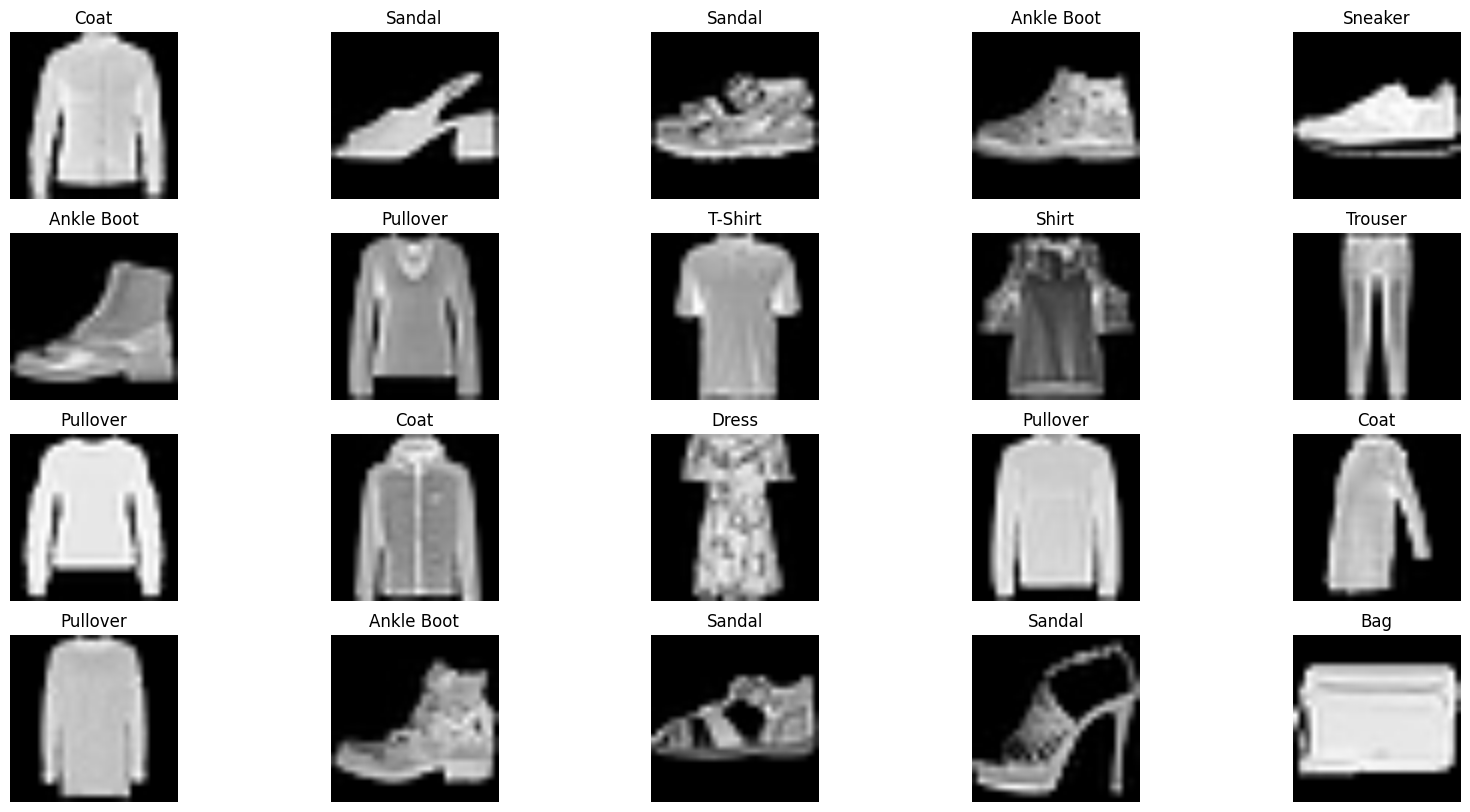

In [36]:
sample_dataset(train_dataset)

In [37]:
def plot_labels(dataset: Dataset) -> None:
    df = dataset.df
    df['label_names'] = df['label'].map(LABELS)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_names'], bins=len(df['label'].unique()), kde=False)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

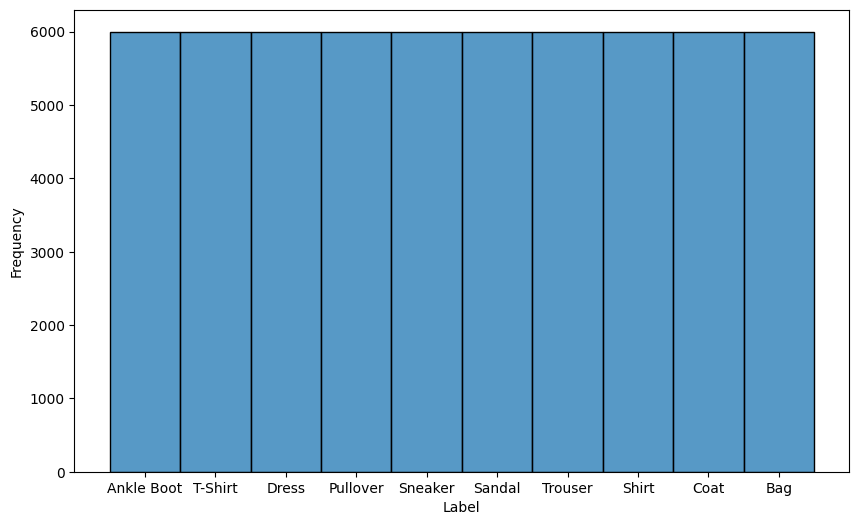

In [38]:
plot_labels(train_dataset)

# 5 Data Cleaning

Checking for null and duplicated values in the dataset. Fortunately, this dataset is already clean and balanced.

In [39]:
print("Null ids:", train_dataset.df.id.isnull().sum())

Null ids: 0


In [40]:
print("Null labels:", train_dataset.df.label.isnull().sum())

Null labels: 0


In [41]:
print("Duplicated rows:", train_dataset.df.duplicated().sum())

Duplicated rows: 0


# 6 Data Augmentation

Increasing the diversity of the training dataset to improve the robustness of our machine learning model. The augmented images are then combined with the original training dataset. This combined dataset is used to train the model.

In [42]:
augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    # transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),  # Crop a random portion of the input and resize it to a given size.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=augmentation, sample=AUGMENTED_RECORDS)
print("Augmentation dataset:", augmented_dataset, len(augmented_dataset), "records")

Augmentation dataset: <apparel.ApparelDataset object at 0x163641c10> 12000 records


In [43]:
tshirt_augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(degrees=10),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    transforms.ToTensor(),
])

tshirt_dataset = ApparelDataset.load(
    csv_path='data/train.csv',
    images_path='data/train',
    preprocessing=tshirt_augmentation,
    sample=AUGMENTED_RECORDS,
    labels=[
        get_label_by_value(TSHIRT),
    ]
)
print("T-Shirt dataset:", tshirt_dataset, len(tshirt_dataset), "records")

T-Shirt dataset: <apparel.ApparelDataset object at 0x164e99730> 1203 records


In [44]:
coat_augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(degrees=10),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    transforms.ToTensor(),
])

coat_dataset = ApparelDataset.load(
    csv_path='data/train.csv',
    images_path='data/train',
    preprocessing=coat_augmentation,
    sample=AUGMENTED_RECORDS,
    labels=[
        get_label_by_value(COAT),
    ]
)
print("Coat dataset:", coat_dataset, len(coat_dataset), "records")

Coat dataset: <apparel.ApparelDataset object at 0x164616ac0> 1199 records


In [45]:
all_datasets = [train_dataset, augmented_dataset, tshirt_dataset, coat_dataset]

augmented_train_dataset = ApparelStackedDataset(all_datasets)
print("Augmented training dataset dataset:", augmented_train_dataset, len(augmented_train_dataset), "records")

assert len(augmented_train_dataset) == sum([len(dataset) for dataset in all_datasets])
assert augmented_train_dataset[0][0].equal(train_dataset[0][0])
assert augmented_train_dataset[0][1] == train_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset)][0].equal(augmented_dataset[0][0])  # Reading the image generates a random variant.
# assert augmented_train_dataset[len(train_dataset)][1] == augmented_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset) + len(augmented_dataset)][1] == tshirt_dataset[0][1]

Augmented training dataset dataset: <apparel.ApparelStackedDataset object at 0x10ba4f6d0> 4 records


AssertionError: 

# 7 Post-Cleaning Exploratory Analysis

Repeating the exploratory analysis to verify the effectiveness of the data cleaning and augmentation steps. This ensures the data augmentation step has not created weird things.

In [ ]:
sample_dataset(augmented_train_dataset)

In [ ]:
plot_labels(augmented_train_dataset)

# 8 Training and Validation Splitting

Splitting the augmented training dataset into training and validation sets using stratified sampling to maintain the same class distribution across both sets.

In [ ]:
df = augmented_train_dataset.df
train_indices, val_indices = train_test_split(
    list(range(len(augmented_train_dataset))), 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=df.label, 
    random_state=RANDOM_STATE
)
assert len(augmented_train_dataset) == len(train_indices) + len(val_indices)

print("Training indices:", train_indices[:10], "...")
print("Validation indices:", val_indices[:10], "...")

In [ ]:
train_subset = Subset(augmented_train_dataset, train_indices)
val_subset = Subset(augmented_train_dataset, val_indices)
assert len(train_subset) + len(val_subset) == len(augmented_train_dataset)
print("Training dataset:", train_subset, len(train_subset), "records")
print("Validation dataset:", val_subset, len(val_subset), "records")

# 8 Model Preparation

Loading a pre-trained Vision Transformer model specifically designed for image classification with 10 labels using `ViTForImageClassification` from the Hugging Face, which is configured for a GPU (if available). Additionally, an Adam optimizer is set up with a learning rate of `1e-4` to adjust the model's parameters during training, and a cross-entropy loss function is defined to measure the performance of the model by comparing its predictions against the true labels.

In [ ]:
class ApparelsModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(ApparelsModel, self).__init__()

        self.base_model = base_model

        # Freeze the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        LAYER_1 = 8192
        LAYER_2 = 2048
        LAYER_3 = 512
        
        self.new_layers = nn.Sequential(
            nn.Linear(base_model.config.hidden_size, LAYER_1),
            nn.BatchNorm1d(LAYER_1),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.

            nn.Linear(LAYER_1, LAYER_2),
            nn.BatchNorm1d(LAYER_2),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.

            nn.Linear(LAYER_2, LAYER_3),
            nn.BatchNorm1d(LAYER_3),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(LAYER_3, num_labels)
        )
        
    def forward(self, x):
        x = self.base_model.vit(x)  # Pass through the base ViT model
        x = x.last_hidden_state[:, 0]  # Get the output of the [CLS] token
        x = self.new_layers(x)  # Pass through the new layers
        return x

    def forward(self, x):
        # profiler = ApparelProfiler("Forward")
        # profiler.measure("BaseModel")
        x = self.base_model.vit(x)
        # profiler.measure("NewLayers")
        x = x.last_hidden_state[:, 0]
        x = self.new_layers(x)
        # profiler.stop()
        return x

In [ ]:
base_model = ViTForImageClassification.from_pretrained(
    PRETRAINED_TRANSFORMER_NAME,
    ignore_mismatched_sizes=True,
    num_labels=len(LABELS)
)

model = ApparelsModel(base_model, num_labels=len(LABELS))
model = model.to(PROCESSOR)
print("Model:", model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
class_weights = torch.tensor([
    WEIGHTS.get(i, 1)
    for i in range(len(LABELS))
], dtype=torch.float).to(PROCESSOR)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Optimizer:", optimizer)
print("Loss function:", loss_function)

# 10 Model Training

Training the model, including forward and backward passes, validation, and early stopping.

In [ ]:
def get_eta(start_time: float, current_batch: int, total_batches: int) -> datetime:
    assert total_batches > 0
    if current_batch < total_batches * 0.01:
        return None
    elapsed_time = time.time() - start_time
    average_time_per_batch = elapsed_time / max(1, current_batch)
    pending_batches = total_batches - current_batch
    return datetime.now() + timedelta(seconds=average_time_per_batch * pending_batches)

In [ ]:
def train_epoch(model: ApparelsModel, epoch: int) -> ApparelsModel:
    batch_size = TRAINING_BATCH_SIZES[epoch]
    loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        pin_memory=False
    )
    print('Training with batch size:', batch_size)
    model.train()
    start_time = time.time()
    for batch_number, batch in enumerate(loader):
        if not (batch_number + 5) % 20:
            print(
                datetime.now(),
                "Train - Batch:", batch_number,
                "of", len(loader),
                "ETA:", get_eta(start_time, batch_number, len(loader))
            )
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch_number == STOP_AT_BATCH: break
    return model

In [ ]:
def evaluate_model(model: ApparelsModel, dataset: Dataset) -> Tuple[float, float, np.array]:
    print('Evaluating model...')
    loader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        num_workers=LOADER_WORKERS,
        pin_memory=False
    )
    loss = 0
    y_hat = []
    y_true = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, batch in enumerate(loader):
            if not (batch_number + 5) % 20:
                print(
                    datetime.now(),
                    "Val - Batch:", batch_number,
                    "of", len(loader),
                    "ETA:", get_eta(start_time, batch_number, len(loader))
                )
            inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
            outputs = model(inputs)
            batch_loss = loss_function(outputs, labels)
            loss += batch_loss.item()
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    loss /= len(loader)
    accuracy = accuracy_score(y_true, y_hat)
    conf_matrix = confusion_matrix(y_true, y_hat)
    return loss, accuracy, conf_matrix

In [ ]:
def train(model: ApparelsModel, epochs: int, best_accuracy: float = 0) -> Tuple[ApparelsModel, List[float]]:
    early_stop_counter = 0
    accuracies: List[float] = []
    start_time = time.time()
    for epoch in range(epochs):
        print(
            datetime.now(),
            "Epoch:", epoch,
            "of", epochs,
            "ETA:", get_eta(start_time, epoch, epochs),
        )
        model = train_epoch(model, epoch)
        val_loss, val_accuracy, _ = evaluate_model(model, val_subset)
        accuracies.append(val_accuracy)
        print(
            datetime.now(),
            "Epoch:", epoch,
            "of", epochs,
            "Loss:", val_loss,
            "Accuracy:", val_accuracy
        ),
        if val_accuracy >= best_accuracy + EARLY_STOPPING_MARGIN:
            best_accuracy = val_accuracy
            early_stop_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            continue
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            model.load_state_dict(torch.load(MODEL_PATH))
            break
        early_stop_counter += 1
    print(datetime.now(), "Training complete!")
    return model, accuracies

In [ ]:
model, accuracies = train(model=model, epochs=EPOCHS)
print(f"Model Accuracy: {accuracies[-1]}")

# 11 Model Evaluation

Eavluating the model's performance on the test set by calculating the test loss, accuracy, and confusion matrix.

In [ ]:
test_loss, test_accuracy, conf_matrix = evaluate_model(model, val_subset)

In [ ]:
print("Test Loss:", test_loss)
print("Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

# 12 Performance Tuning

Visualizing the validation loss and test loss over epochs and the confusion matrix. This step help update the settings of the model to improve the results. Additionally, there are multiple versions of this model, so at the end of the day, we only keep the best one.

In [ ]:
assert len(accuracies) > 0
assert test_accuracy > 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy')
plt.plot(range(1, len(accuracies) + 1), [test_accuracy for _ in range(len(accuracies))], label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13 Prediction

Generating the CSV to submit to DataHack.

In [ ]:
submission_dataset = ApparelDataset.load(csv_path='data/test.csv', images_path='data/test', preprocessing=preprocessing)
print("Submission dataset:", submission_dataset, len(submission_dataset), "records.")

In [ ]:
def predict(model: ApparelsModel, dataset: Dataset) -> np.array:
    loader = DataLoader(
        submission_dataset,
        batch_size=EVALUATION_BATCH_SIZE,
        shuffle=False,
        num_workers=LOADER_WORKERS,
        pin_memory=False
    )
    y_hat = []
    model.eval() # Sets the model in evaluation model, which disables Dropout.
    start_time = time.time()
    with torch.no_grad():
        for batch_number, inputs in enumerate(loader):
            if not (batch_number + 5) % 20:
                print(
                    datetime.now(),
                    "Prediction - Batch:", batch_number,
                    "of", len(loader),
                    "ETA:", get_eta(start_time, batch_number, len(loader))
                )
            inputs = inputs.to(PROCESSOR)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_hat.extend(predictions.cpu().numpy())
            if batch_number == STOP_AT_BATCH: break
    return y_hat

In [ ]:
predictions = predict(model, submission_dataset)

In [ ]:
if isinstance(STOP_AT_BATCH, int) and STOP_AT_BATCH >= 0:
    submission_dataset.df = submission_dataset.df.iloc[:len(predictions)].copy()  # When not all batches are executed, the output is trimmed.
assert len(predictions) == len(submission_dataset)
submission_dataset.df['label'] = predictions
submission_dataset.df.to_csv(PREDICTIONS_PATH, index=False)

In [ ]:
sample_dataset(submission_dataset)